**TNC Implementation with K-means**

Loading data...
Preparing data...

Training TNC model...
Epoch 0: Train Loss = 0.6945, Val Loss = 0.6927
Epoch 10: Train Loss = 0.6935, Val Loss = 0.6944
Epoch 20: Train Loss = 0.6906, Val Loss = 0.6910
Epoch 30: Train Loss = 0.6908, Val Loss = 0.6922
Early stopping at epoch 39
Test Loss: 0.6927

Clustering...
Silhouette Score: 0.7664

Visualizing results...


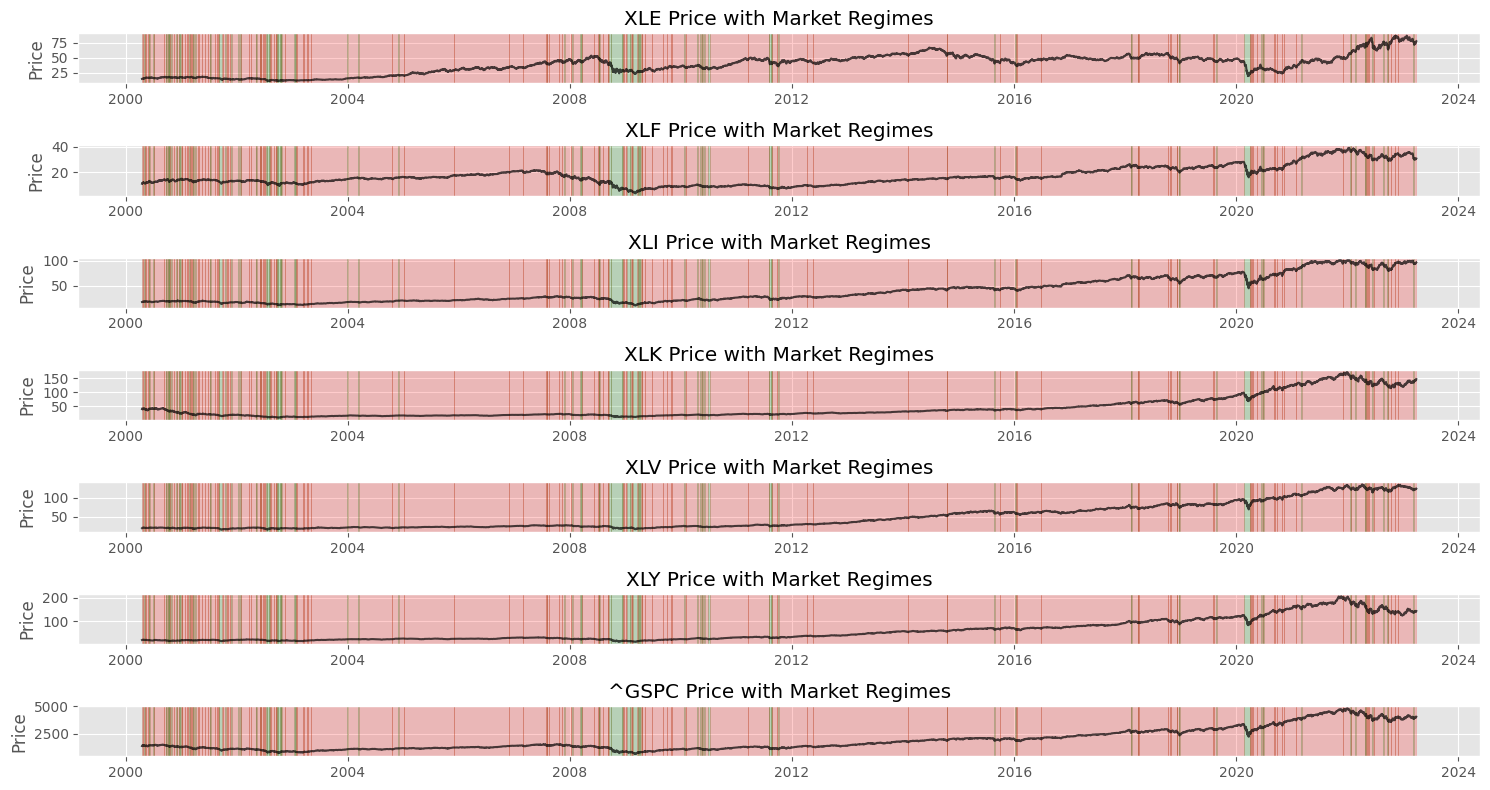

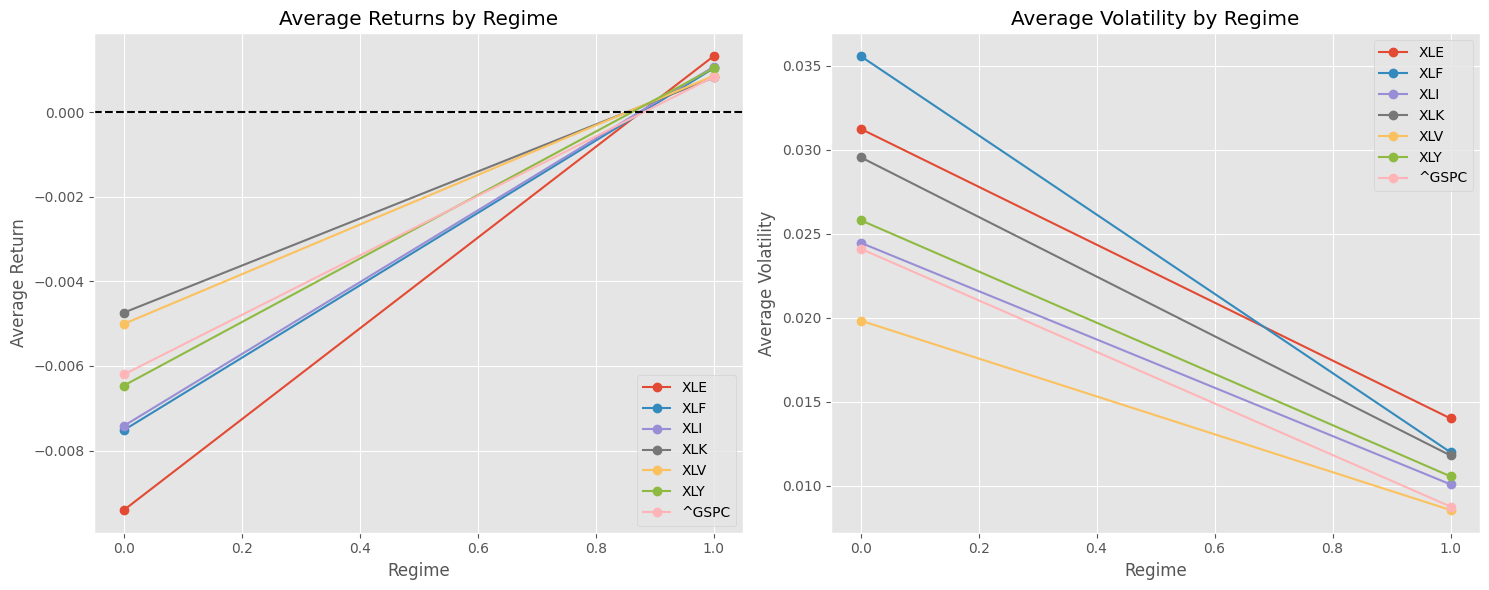

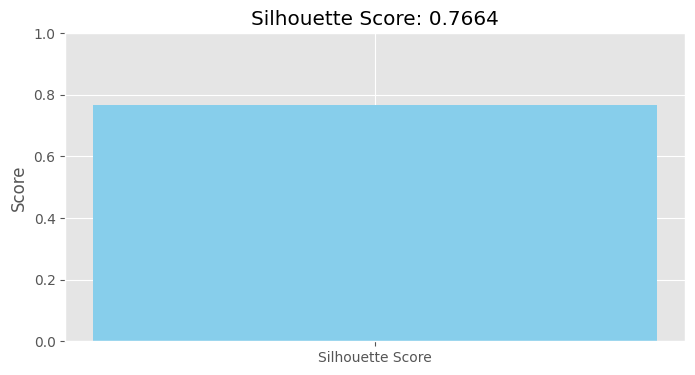


Results saved to 'market_regimes_results.csv'

Analysis complete!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True

#TNC Model
class TNCNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.extend([nn.Linear(prev_dim, dim), nn.ReLU()])
            prev_dim = dim
        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.encoder(x)

class TemporalNeighborhoodCoding:
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], lr=0.001, batch_size=64, w_size=30):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = TNCNet(input_dim, hidden_dims).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_size = batch_size
        self.w_size = w_size

    def train_model(self, train_loader, val_loader, epochs=100):
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0

        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            for anchor, pos, neg in train_loader:
                anchor, pos, neg = [x.to(self.device) for x in [anchor, pos, neg]]

                a_rep = self.model(anchor)
                p_rep = self.model(pos)
                n_rep = self.model(neg)

                pos_sim = F.cosine_similarity(a_rep, p_rep)
                neg_sim = F.cosine_similarity(a_rep, n_rep)
                loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim))).mean()

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()


            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for anchor, pos, neg in val_loader:
                    anchor, pos, neg = [x.to(self.device) for x in [anchor, pos, neg]]

                    a_rep = self.model(anchor)
                    p_rep = self.model(pos)
                    n_rep = self.model(neg)

                    pos_sim = F.cosine_similarity(a_rep, p_rep)
                    neg_sim = F.cosine_similarity(a_rep, n_rep)
                    loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim))).mean()
                    val_loss += loss.item()

            train_loss /= len(train_loader)
            val_loss /= len(val_loader)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0

                torch.save(self.model.state_dict(), 'best_tnc_model.pth')
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break


        self.model.load_state_dict(torch.load('best_tnc_model.pth'))
        return best_val_loss

    def fit(self, data, test_size=0.2, val_size=0.2, epochs=100):
        full_data = torch.FloatTensor(data.values)
        train_size = int((1 - test_size - val_size) * len(full_data))
        val_size = int(val_size * len(full_data))
        test_size = len(full_data) - train_size - val_size

        train_data, val_data, test_data = random_split(full_data, [train_size, val_size, test_size])
        train_dataset = TNCDataset(train_data, self.w_size)
        val_dataset = TNCDataset(val_data, self.w_size)
        test_dataset = TNCDataset(test_data, self.w_size)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        best_val_loss = self.train_model(train_loader, val_loader, epochs)

        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for anchor, pos, neg in test_loader:
                anchor, pos, neg = [x.to(self.device) for x in [anchor, pos, neg]]

                a_rep = self.model(anchor)
                p_rep = self.model(pos)
                n_rep = self.model(neg)

                pos_sim = F.cosine_similarity(a_rep, p_rep)
                neg_sim = F.cosine_similarity(a_rep, n_rep)
                loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim))).mean()
                test_loss += loss.item()

        test_loss /= len(test_loader)
        print(f"Test Loss: {test_loss:.4f}")

        return best_val_loss, test_loss

    def get_representations(self, data):
        self.model.eval()
        with torch.no_grad():
            return self.model(torch.FloatTensor(data.values).to(self.device)).cpu().numpy()

class TNCDataset(Dataset):
    def __init__(self, data, w_size=30):
        self.data = data
        self.w_size = w_size
        self.T = len(data)

    def __len__(self):
        return self.T

    def __getitem__(self, idx):
        anchor = self.data[idx]
        pos_idx = np.random.randint(max(0, idx-self.w_size), min(self.T, idx+self.w_size+1))
        while pos_idx == idx:
            pos_idx = np.random.randint(max(0, idx-self.w_size), min(self.T, idx+self.w_size+1))
        positive = self.data[pos_idx]

        if idx - self.w_size <= 0:
            neg_idx = np.random.randint(min(idx + self.w_size + 1, self.T-1), self.T)
        elif idx + self.w_size >= self.T - 1:
            neg_idx = np.random.randint(0, max(0, idx - self.w_size))
        else:
            if np.random.random() < 0.5:
                neg_idx = np.random.randint(0, max(0, idx - self.w_size))
            else:
                neg_idx = np.random.randint(min(idx + self.w_size + 1, self.T-1), self.T)

        negative = self.data[neg_idx]
        return anchor, positive, negative
#Preprocessing the data
def prepare_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Date', 'Ticker'])

    df['Returns'] = df.groupby('Ticker')['Close'].pct_change()
    df['Volatility'] = df.groupby('Ticker')['Returns'].rolling(5).std().reset_index(level=0, drop=True)

    features = {}
    for ticker in df['Ticker'].unique():
        tdf = df[df['Ticker'] == ticker].set_index('Date')

        #Momentum indicators
        tdf['Momentum_5'] = tdf['Close']/tdf['Close'].shift(5) - 1
        tdf['Momentum_10'] = tdf['Close']/tdf['Close'].shift(10) - 1

        #Volume features
        tdf['Volume_Change'] = tdf['Volume'].pct_change()
        tdf['Volume_Spike'] = tdf['Volume'] / tdf['Volume'].rolling(10).mean()

        #Price action
        tdf['Range'] = (tdf['High'] - tdf['Low']) / tdf['Close']
        tdf['Body'] = (tdf['Close'] - tdf['Open']) / tdf['Close']

        for col in ['Returns', 'Volatility', 'Momentum_5', 'Momentum_10',
                   'Volume_Change', 'Volume_Spike', 'Range', 'Body']:
            features[f"{ticker}_{col}"] = tdf[col]

    features_df = pd.DataFrame(features).dropna()
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(features_df), index=features_df.index, columns=features_df.columns), df
def visualize_results(raw_df, features_df, labels, score):
    regime_df = pd.DataFrame({
        'Date': features_df.index,
        'Regime': labels
    })
    merged_df = raw_df.merge(regime_df, on='Date', how='inner')

    if 'Returns' not in merged_df.columns:
        merged_df['Returns'] = merged_df.groupby('Ticker')['Close'].pct_change()
    if 'Volatility' not in merged_df.columns:
        merged_df['Volatility'] = merged_df.groupby('Ticker')['Returns'].rolling(5).std().reset_index(level=0, drop=True)

    #Plot price with regime background
    plt.figure(figsize=(15, 8))

    #Get unique tickers
    tickers = merged_df['Ticker'].unique()

    #subplots for each ticker
    for i, ticker in enumerate(tickers, 1):
        ax = plt.subplot(len(tickers), 1, i)
        ticker_data = merged_df[merged_df['Ticker'] == ticker].sort_values('Date')

        #Plot price
        ax.plot(ticker_data['Date'], ticker_data['Close'], label=f'{ticker} Price', color='black', alpha=0.7)

        #Color background by regime
        prev_regime = None
        start_date = None

        for _, row in ticker_data.iterrows():
            current_regime = row['Regime']

            if prev_regime is None:
                start_date = row['Date']
                prev_regime = current_regime
            elif current_regime != prev_regime:
                color = 'green' if prev_regime == 0 else 'red'
                ax.axvspan(start_date, row['Date'], alpha=0.2, color=color)
                start_date = row['Date']
                prev_regime = current_regime

        if start_date is not None:
            color = 'green' if prev_regime == 0 else 'red'
            ax.axvspan(start_date, ticker_data['Date'].iloc[-1], alpha=0.2, color=color)

        ax.set_title(f'{ticker} Price with Market Regimes')
        ax.set_ylabel('Price')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    #Plot regime characteristics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    #Calculate average returns and volatility by regime
    stats = merged_df.groupby(['Regime', 'Ticker']).agg({
        'Returns': ['mean', 'std'],
        'Volatility': 'mean'
    }).reset_index()

    stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in stats.columns.values]

    #Plot returns
    for ticker in stats['Ticker'].unique():
        ticker_stats = stats[stats['Ticker'] == ticker]
        ax1.plot(ticker_stats['Regime'], ticker_stats['Returns_mean'], 'o-', label=ticker)

    ax1.set_title('Average Returns by Regime')
    ax1.set_xlabel('Regime')
    ax1.set_ylabel('Average Return')
    ax1.axhline(0, color='black', linestyle='--')
    ax1.legend()
    ax1.grid(True)

    #Plot volatility
    for ticker in stats['Ticker'].unique():
        ticker_stats = stats[stats['Ticker'] == ticker]
        ax2.plot(ticker_stats['Regime'], ticker_stats['Volatility_mean'], 'o-', label=ticker)

    ax2.set_title('Average Volatility by Regime')
    ax2.set_xlabel('Regime')
    ax2.set_ylabel('Average Volatility')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    #Silhouette visualization
    plt.figure(figsize=(8, 4))
    plt.bar(['Silhouette Score'], [score], color='skyblue')
    plt.ylim(0, 1)
    plt.title(f'Silhouette Score: {score:.4f}')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

    return merged_df
def main(data_path='/content/melted_data.csv'):
    df = pd.read_csv(data_path)
    features_df, raw_df = prepare_data(df)

    #Train TNC model with train-val-test split
    print("\nTraining TNC model...")
    tnc = TemporalNeighborhoodCoding(
        input_dim=features_df.shape[1],
        hidden_dims=[256, 128, 64],
        lr=0.001,
        batch_size=64,
        w_size=30
    )
    val_loss, test_loss = tnc.fit(features_df, test_size=0.2, val_size=0.2, epochs=100)

    #Get representations and cluster
    print("\nClustering...")
    representations = tnc.get_representations(features_df)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels = kmeans.fit_predict(representations)
    score = silhouette_score(representations, labels)
    print(f"Silhouette Score: {score:.4f}")

    #Visualize results
    print("\nVisualizing results...")
    merged_df = visualize_results(raw_df, features_df, labels, score)

    merged_df[['Date', 'Ticker', 'Close', 'Returns', 'Volatility', 'Regime']].to_csv('market_regimes_results.csv', index=False)
    print("\nResults saved to 'market_regimes_results.csv'")

    return merged_df, score, val_loss, test_loss

if __name__ == "__main__":
    merged_df, score, val_loss, test_loss = main('/content/melted_data.csv')

**Trying different clustering methods and cluster sizes**

Loading data from melted_data.csv...
Preparing data for TNC...
Final feature matrix shape: (5776, 56)

Training TNC model...
Using device: cuda
Data Split:
Training set: 3466 samples
Validation set: 1155 samples
Test set: 1155 samples
Epoch 1/100, Train Loss: 0.6941, Val Loss: 0.6969
Epoch 2/100, Train Loss: 0.6931, Val Loss: 0.6933
Epoch 3/100, Train Loss: 0.6937, Val Loss: 0.6941
Epoch 4/100, Train Loss: 0.6930, Val Loss: 0.6936
Epoch 5/100, Train Loss: 0.6935, Val Loss: 0.6939
Epoch 6/100, Train Loss: 0.6926, Val Loss: 0.6943
Epoch 7/100, Train Loss: 0.6936, Val Loss: 0.6934
Epoch 8/100, Train Loss: 0.6931, Val Loss: 0.6933
Epoch 9/100, Train Loss: 0.6929, Val Loss: 0.6933
Epoch 10/100, Train Loss: 0.6927, Val Loss: 0.6929
Epoch 11/100, Train Loss: 0.6930, Val Loss: 0.6932
Epoch 12/100, Train Loss: 0.6929, Val Loss: 0.6934
Epoch 13/100, Train Loss: 0.6932, Val Loss: 0.6941
Epoch 14/100, Train Loss: 0.6931, Val Loss: 0.6941
Epoch 15/100, Train Loss: 0.6933, Val Loss: 0.6929
Epoch 16/

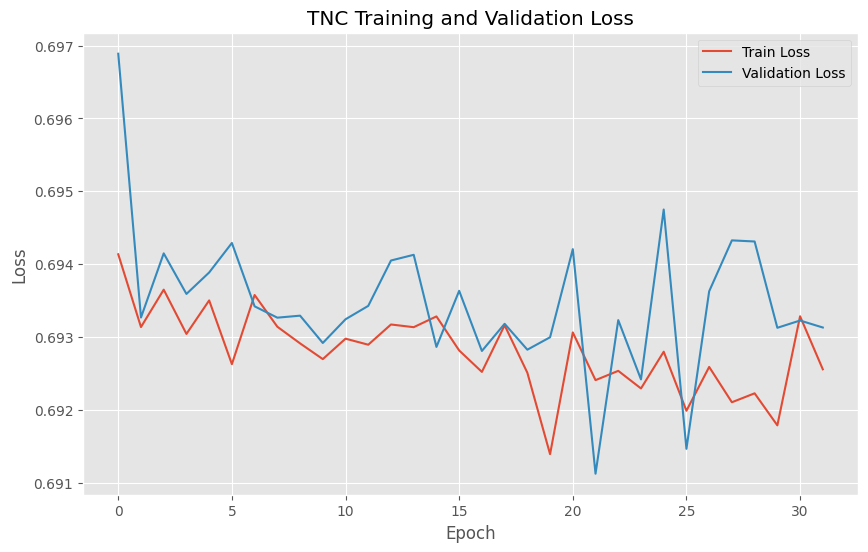


Extracting learned representations...

Clustering and evaluating with silhouette score...
Number of clusters: 2, Silhouette Score: 0.7421
Number of clusters: 3, Silhouette Score: 0.5922
Number of clusters: 4, Silhouette Score: 0.5457
Number of clusters: 5, Silhouette Score: 0.5037
Number of clusters: 6, Silhouette Score: 0.4900
Number of clusters: 7, Silhouette Score: 0.3894
Number of clusters: 8, Silhouette Score: 0.3175
Number of clusters: 9, Silhouette Score: 0.3097
Number of clusters: 10, Silhouette Score: 0.2960

Best number of clusters: 2 with Silhouette Score: 0.7421

Visualizing market regimes...


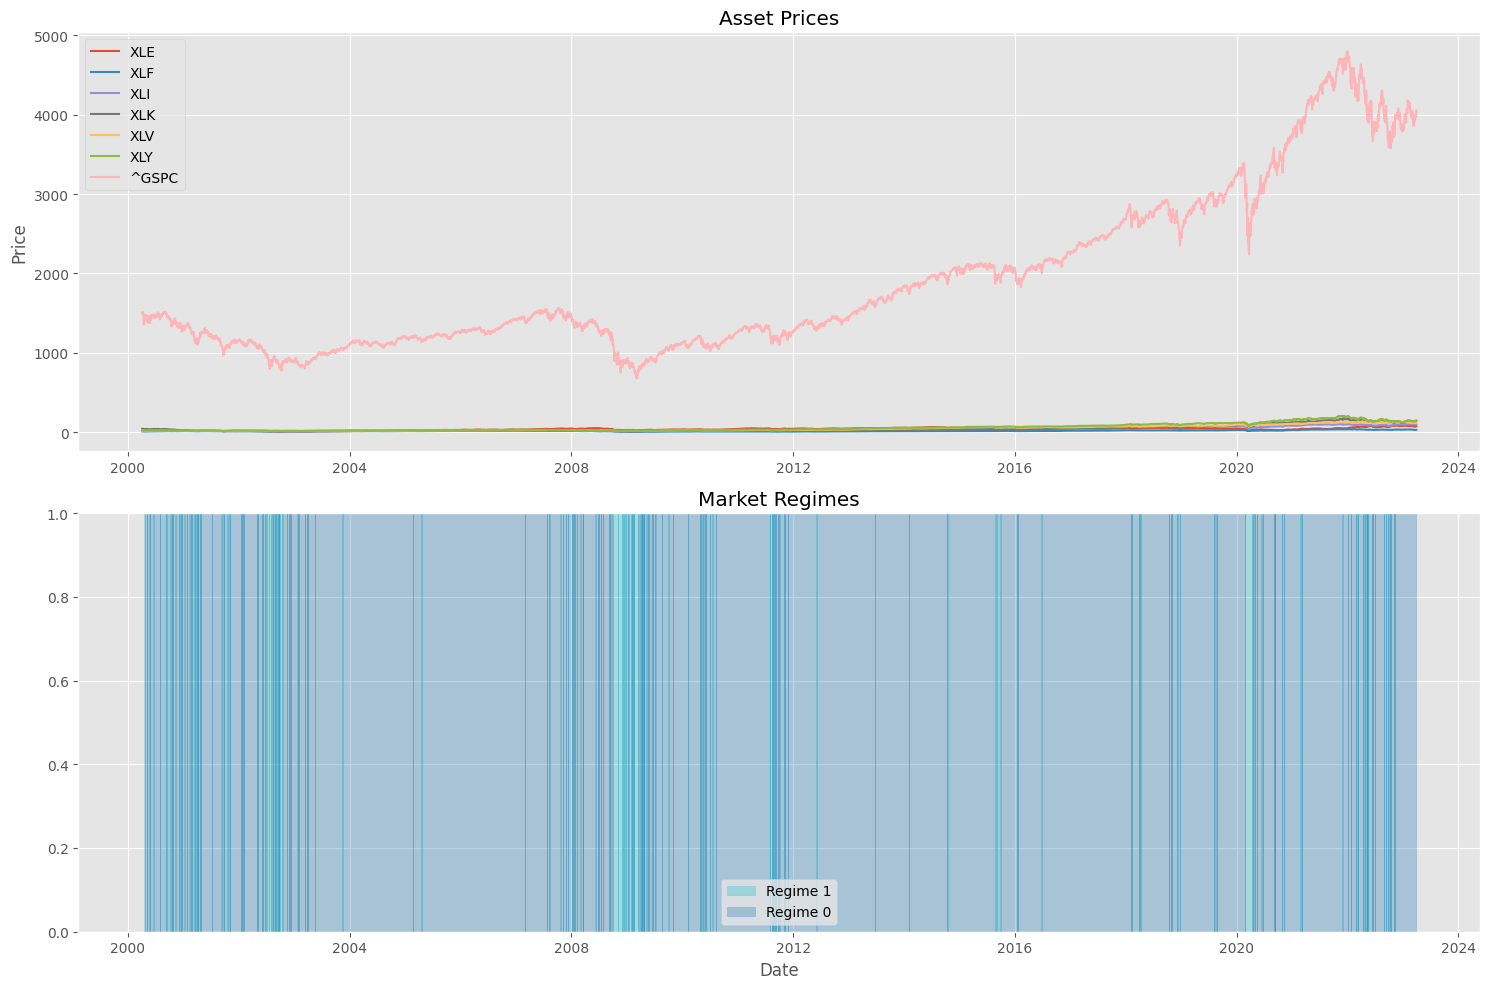


Regime Analysis:

Regime 0 (5333 days):
  XLE: Avg Return: 0.16%, Avg Volatility: 1.39%, Max Return: 10.62%, Min Return: -6.42%
  XLF: Avg Return: 0.15%, Avg Volatility: 1.18%, Max Return: 10.14%, Min Return: -5.70%
  XLI: Avg Return: 0.15%, Avg Volatility: 1.00%, Max Return: 6.59%, Min Return: -3.93%
  XLK: Avg Return: 0.15%, Avg Volatility: 1.18%, Max Return: 10.37%, Min Return: -6.19%
  XLV: Avg Return: 0.11%, Avg Volatility: 0.85%, Max Return: 4.44%, Min Return: -3.37%
  XLY: Avg Return: 0.15%, Avg Volatility: 1.05%, Max Return: 5.76%, Min Return: -3.98%
  ^GSPC: Avg Return: 0.13%, Avg Volatility: 0.87%, Max Return: 4.08%, Min Return: -2.64%
  Characteristic: Mixed/Transition Regime

Regime 1 (443 days):
  XLE: Avg Return: -1.34%, Avg Volatility: 3.33%, Max Return: 16.47%, Min Return: -20.14%
  XLF: Avg Return: -1.33%, Avg Volatility: 3.89%, Max Return: 16.46%, Min Return: -16.67%
  XLI: Avg Return: -1.32%, Avg Volatility: 2.67%, Max Return: 12.65%, Min Return: -11.34%
  XLK: Avg 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
class TNCNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32]):
        super(TNCNet, self).__init__()

        layers = []
        prev_dim = input_dim

        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            prev_dim = dim

        self.encoder = nn.Sequential(*layers)
        self.representation_dim = hidden_dims[-1]

    def forward(self, x):
        return self.encoder(x)

class TemporalNeighborhoodCoding:
    def __init__(self, input_dim, hidden_dims=[64, 32], learning_rate=0.001, batch_size=32, w_size=10):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        self.model = TNCNet(input_dim, hidden_dims).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.w_size = w_size
        self.original_data = None

    def split_data(self, data, val_split=0.2, test_split=0.2):
        self.original_data = data
        X_tensor = torch.FloatTensor(data.values)
        total_size = len(X_tensor)
        test_size = int(total_size * test_split)
        val_size = int(total_size * val_split)
        train_size = total_size - test_size - val_size
        train_data, val_data, test_data = random_split(
            X_tensor,
            [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )

        print(f"Data Split:")
        print(f"Training set: {len(train_data)} samples")
        print(f"Validation set: {len(val_data)} samples")
        print(f"Test set: {len(test_data)} samples")

        return train_data, val_data, test_data

    def fit(self, data, epochs=50, val_split=0.2, test_split=0.2, patience=10):
        train_data, val_data, test_data = self.split_data(data, val_split, test_split)
        train_dataset = TNCDataset(train_data, self.w_size)
        val_dataset = TNCDataset(val_data, self.w_size)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        best_val_loss = float('inf')
        epochs_no_improve = 0
        history = {'train_loss': [], 'val_loss': []}
        early_stopping_model = None

        for epoch in range(epochs):
            self.model.train()
            train_epoch_loss = 0

            for batch in train_loader:
                anchor, pos, neg = [b.to(self.device) for b in batch]
                anchor_rep = self.model(anchor)
                pos_rep = self.model(pos)
                neg_rep = self.model(neg)
                pos_sim = F.cosine_similarity(anchor_rep, pos_rep)
                neg_sim = F.cosine_similarity(anchor_rep, neg_rep)

                #TNC loss Calculation- maximize positive similarity and minimize negative similarity
                loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim))).mean()

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_epoch_loss += loss.item()

            self.model.eval()
            val_epoch_loss = 0

            with torch.no_grad():
                for batch in val_loader:
                    anchor, pos, neg = [b.to(self.device) for b in batch]

                    anchor_rep = self.model(anchor)
                    pos_rep = self.model(pos)
                    neg_rep = self.model(neg)

                    pos_sim = F.cosine_similarity(anchor_rep, pos_rep)
                    neg_sim = F.cosine_similarity(anchor_rep, neg_rep)

                    loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim))).mean()

                    val_epoch_loss += loss.item()
            train_loss = train_epoch_loss / len(train_loader)
            val_loss = val_epoch_loss / len(val_loader)

            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)

            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                early_stopping_model = self.model.state_dict().copy()
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        if early_stopping_model:
            self.model.load_state_dict(early_stopping_model)

        plt.figure(figsize=(10, 6))
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('TNC Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        return history

    def get_representations(self, data=None):
        if data is None:
            data = self.original_data

        if isinstance(data, pd.DataFrame):
            X_tensor = torch.FloatTensor(data.values)
        else:
            X_tensor = data
        X_tensor = X_tensor.to(self.device)
        self.model.eval()
        with torch.no_grad():
            representations = self.model(X_tensor).cpu().numpy()

        return representations

class TNCDataset(Dataset):
    def __init__(self, data, w_size=10):
        self.data = data
        self.w_size = w_size
        self.T = len(data)

    def __len__(self):
        return self.T

    def __getitem__(self, idx):
        anchor = self.data[idx]

        #Positive sample
        pos_idx = np.random.randint(max(0, idx-self.w_size), min(self.T, idx+self.w_size+1))
        while pos_idx == idx:
            pos_idx = np.random.randint(max(0, idx-self.w_size), min(self.T, idx+self.w_size+1))
        positive = self.data[pos_idx]

        #Negative sample
        if idx - self.w_size <= 0:
            neg_idx = np.random.randint(min(idx + self.w_size + 1, self.T-1), self.T)
        elif idx + self.w_size >= self.T - 1:
            neg_idx = np.random.randint(0, max(0, idx - self.w_size))
        else:
            if np.random.random() < 0.5:
                neg_idx = np.random.randint(0, max(0, idx - self.w_size))
            else:
                neg_idx = np.random.randint(min(idx + self.w_size + 1, self.T-1), self.T)

        if neg_idx >= self.T:
            neg_idx = 0

        negative = self.data[neg_idx]

        return anchor, positive, negative

def prepare_data(df):
    print("Preparing data for TNC...")
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    pivot_data = {}

    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].set_index('Date')
        ticker_data['Returns'] = ticker_data['Close'].pct_change()
        ticker_data['LogReturns'] = np.log(ticker_data['Close']/ticker_data['Close'].shift(1))
        ticker_data['Volatility'] = ticker_data['Returns'].rolling(5).std()
        ticker_data['MA5'] = ticker_data['Close'].rolling(5).mean()
        ticker_data['MA10'] = ticker_data['Close'].rolling(10).mean()
        ticker_data['Momentum'] = ticker_data['Close'] / ticker_data['Close'].shift(5)
        ticker_data['RelVolume'] = ticker_data['Volume'] / ticker_data['Volume'].rolling(10).mean()
        ticker_data['HL_Range'] = (ticker_data['High'] - ticker_data['Low']) / ticker_data['Close']
        for col in ['Returns', 'LogReturns', 'Volatility', 'MA5', 'MA10', 'Momentum', 'RelVolume', 'HL_Range']:
            pivot_data[f'{ticker}_{col}'] = ticker_data[col]


    features_df = pd.DataFrame(pivot_data)
    features_df = features_df.dropna()

    print(f"Final feature matrix shape: {features_df.shape}")
    return features_df, df

#Trying different cluster sizes
def cluster_and_evaluate(representations, n_clusters_range=range(2, 11)):
    silhouette_scores = []
    models = []

    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(representations)
        if len(np.unique(labels)) <= 1:
            silhouette_scores.append(-1)
            models.append(kmeans)
            continue

        score = silhouette_score(representations, labels)
        silhouette_scores.append(score)
        models.append(kmeans)
        print(f'Number of clusters: {n_clusters}, Silhouette Score: {score:.4f}')

    best_idx = np.argmax(silhouette_scores)
    best_n_clusters = n_clusters_range[best_idx]
    best_score = silhouette_scores[best_idx]
    best_model = models[best_idx]

    print(f'\nBest number of clusters: {best_n_clusters} with Silhouette Score: {best_score:.4f}')

    return best_model, best_n_clusters, best_score

#Visualize market regimes
def visualize_regimes(df, features_df, labels, n_clusters):
    regime_df = pd.DataFrame(index=features_df.index)
    regime_df['Regime'] = labels
    unique_dates = df.drop_duplicates('Date')[['Date']].set_index('Date')
    regime_dates = unique_dates.join(regime_df, how='inner')
    plt.figure(figsize=(15, 10))
    ax1 = plt.subplot(211)
    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker].set_index('Date')
        plt.plot(ticker_data.index, ticker_data['Close'], label=ticker)

    plt.legend()
    plt.title('Asset Prices')
    plt.ylabel('Price')
    ax2 = plt.subplot(212, sharex=ax1)
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    prev_regime = None
    start_date = None
    regime_dates = regime_dates.sort_index()

    for date, row in regime_dates.iterrows():
        current_regime = row['Regime']

        if prev_regime is None:
            start_date = date
            prev_regime = current_regime
        elif current_regime != prev_regime:
            plt.axvspan(start_date, date, alpha=0.3, color=colors[int(prev_regime)],
                      label=f'Regime {int(prev_regime)}')
            start_date = date
            prev_regime = current_regime

    if start_date is not None and prev_regime is not None:
        plt.axvspan(start_date, regime_dates.index[-1], alpha=0.3, color=colors[int(prev_regime)],
                  label=f'Regime {int(prev_regime)}')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title('Market Regimes')
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

    return regime_dates

#Analyze regime characteristics
def analyze_regimes(df, features_df, labels, n_clusters):
    regime_df = pd.DataFrame(index=features_df.index)
    regime_df['Regime'] = labels
    regime_features = features_df.copy()
    regime_features['Regime'] = labels

    print("\nRegime Analysis:")
    for regime in range(n_clusters):
        regime_data = regime_features[regime_features['Regime'] == regime]

        print(f"\nRegime {regime} ({len(regime_data)} days):")
        ticker_stats = {}

        for ticker in df['Ticker'].unique():
            returns_col = f'{ticker}_Returns'
            vol_col = f'{ticker}_Volatility'

            if returns_col in regime_data.columns and vol_col in regime_data.columns:
                avg_return = regime_data[returns_col].mean() * 100
                avg_vol = regime_data[vol_col].mean() * 100
                max_return = regime_data[returns_col].max() * 100
                min_return = regime_data[returns_col].min() * 100

                ticker_stats[ticker] = {
                    'avg_return': avg_return,
                    'avg_vol': avg_vol,
                    'max_return': max_return,
                    'min_return': min_return
                }

                print(f"  {ticker}: Avg Return: {avg_return:.2f}%, Avg Volatility: {avg_vol:.2f}%, "
                      f"Max Return: {max_return:.2f}%, Min Return: {min_return:.2f}%")

        if len(ticker_stats) > 0:
            avg_returns = [stats['avg_return'] for stats in ticker_stats.values()]
            avg_vols = [stats['avg_vol'] for stats in ticker_stats.values()]

            if all(r > 0.5 for r in avg_returns) and all(v < 1.5 for v in avg_vols):
                print("  Characteristic: Bull Market (High Returns, Low Volatility)")
            elif all(r < -0.5 for r in avg_returns) and all(v > 1.5 for v in avg_vols):
                print("  Characteristic: Bear Market (Negative Returns, High Volatility)")
            elif all(abs(r) < 0.5 for r in avg_returns) and all(v < 1.0 for v in avg_vols):
                print("  Characteristic: Stable/Range-Bound (Low Returns, Low Volatility)")
            elif any(v > 2.0 for v in avg_vols):
                print("  Characteristic: High Volatility Regime")
            else:
                print("  Characteristic: Mixed/Transition Regime")

    return regime_df

#Improve silhouette score
def improve_silhouette_score(representations):
    #PCA dimensionality reduction
    from sklearn.decomposition import PCA
    pca = PCA(n_components=0.9)
    pca_representations = pca.fit_transform(representations)

    print(f"PCA reduced dimensions from {representations.shape[1]} to {pca_representations.shape[1]} features")
    print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

    #Try different clustering methods- KMeans, Agglomerative DBSCAN and Gaussian Mixutre
    methods = {
        'KMeans': KMeans(n_clusters=3, random_state=42, n_init=10),
        'Agglomerative': None,
        'DBSCAN': None,
        'Gaussian Mixture': None
    }

    best_score = -1
    best_method = None
    best_labels = None
    best_n_clusters = 0

    #KMeans with PCA
    labels = methods['KMeans'].fit_predict(pca_representations)
    if len(np.unique(labels)) > 1:
        score = silhouette_score(pca_representations, labels)
        print(f"KMeans with PCA: Silhouette Score: {score:.4f}")

        if score > best_score:
            best_score = score
            best_method = 'KMeans with PCA'
            best_labels = labels
            best_n_clusters = 3

    # Agglomerative Clustering
    if best_score < 0:
        from sklearn.cluster import AgglomerativeClustering

        for n_clusters in range(2, 6):
            agg = AgglomerativeClustering(n_clusters=n_clusters)
            labels = agg.fit_predict(pca_representations)

            if len(np.unique(labels)) > 1:
                score = silhouette_score(pca_representations, labels)
                print(f"Agglomerative with {n_clusters} clusters: Silhouette Score: {score:.4f}")

                if score > best_score:
                    best_score = score
                    best_method = f'Agglomerative with {n_clusters} clusters'
                    best_labels = labels
                    best_n_clusters = n_clusters

    # DBSCAN
    if best_score < 0:
        from sklearn.cluster import DBSCAN

        for eps in [0.3, 0.5, 0.7, 1.0]:
            dbscan = DBSCAN(eps=eps, min_samples=5)
            labels = dbscan.fit_predict(pca_representations)
            if len(np.unique(labels)) <= 1 or -1 in labels:
                continue

            score = silhouette_score(pca_representations, labels)
            print(f"DBSCAN with eps={eps}: Silhouette Score: {score:.4f}")

            if score > best_score:
                best_score = score
                best_method = f'DBSCAN with eps={eps}'
                best_labels = labels
                best_n_clusters = len(np.unique(labels))
    if best_score < 0:
        from sklearn.mixture import GaussianMixture

        for n_components in range(2, 6):
            gmm = GaussianMixture(n_components=n_components, random_state=42)
            labels = gmm.fit_predict(pca_representations)

            if len(np.unique(labels)) > 1:
                score = silhouette_score(pca_representations, labels)
                print(f"Gaussian Mixture with {n_components} components: Silhouette Score: {score:.4f}")

                if score > best_score:
                    best_score = score
                    best_method = f'Gaussian Mixture with {n_components} components'
                    best_labels = labels
                    best_n_clusters = n_components

    print(f"\nBest method: {best_method}")
    print(f"Best silhouette score: {best_score:.4f}")

    return best_labels, best_n_clusters, best_score

def main(data_path='melted_data.csv'):
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    features_df, raw_df = prepare_data(df)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)
    input_dim = scaled_features.shape[1]
    tnc = TemporalNeighborhoodCoding(
        input_dim=input_dim,
        hidden_dims=[128, 64, 32],
        w_size=15,
        batch_size=64,
        learning_rate=0.001
    )
    history = tnc.fit(
        pd.DataFrame(scaled_features),
        epochs=100,
        val_split=0.2,
        test_split=0.2,
        patience=10
    )

    print("\nExtracting learned representations...")
    representations = tnc.get_representations()
    best_model, best_n_clusters, best_score = cluster_and_evaluate(representations)
    if best_score < 0:
        print("\nWarning: Best silhouette score is negative. Trying different approaches...")
        labels, best_n_clusters, best_score = improve_silhouette_score(representations)
    else:
        labels = best_model.labels_
    regime_dates = visualize_regimes(raw_df, features_df, labels, best_n_clusters)
    regime_df = analyze_regimes(raw_df, features_df, labels, best_n_clusters)

    print(f"\nFinal Silhouette Score: {best_score:.4f}")

    regime_output = pd.DataFrame({
        'Date': regime_dates.index,
        'Regime': regime_dates['Regime']
    })
    regime_output.to_csv('market_regimes.csv', index=False)
    print("\nRegime assignments saved to 'market_regimes.csv'")

    return regime_df, best_score, representations

if __name__ == "__main__":
    regime_df, silhouette_score, representations = main('melted_data.csv')

**HYPERPARAMETER TUNING**

Loading data from /content/melted_data.csv...
Preparing data for TNC...
Final feature matrix shape: (5776, 56)
Starting hyperparameter grid search...
Total parameter combinations to evaluate: 432

Evaluating combination 1/432
{'batch_size': 32, 'hidden_dims': [64, 32], 'learning_rate': 0.0001, 'w_size': 5, 'weight_decay': 0.0}
Using device: cuda
Loss: 0.6363, Best Silhouette Score: 0.6394, Best Clusters: 3

Evaluating combination 2/432
{'batch_size': 32, 'hidden_dims': [64, 32], 'learning_rate': 0.0001, 'w_size': 5, 'weight_decay': 0.0001}
Using device: cuda
Loss: 0.6363, Best Silhouette Score: 0.6216, Best Clusters: 3

Evaluating combination 3/432
{'batch_size': 32, 'hidden_dims': [64, 32], 'learning_rate': 0.0001, 'w_size': 5, 'weight_decay': 0.001}
Using device: cuda
Loss: 0.6102, Best Silhouette Score: 0.5782, Best Clusters: 2

Evaluating combination 4/432
{'batch_size': 32, 'hidden_dims': [64, 32], 'learning_rate': 0.0001, 'w_size': 10, 'weight_decay': 0.0}
Using device: cuda
Loss

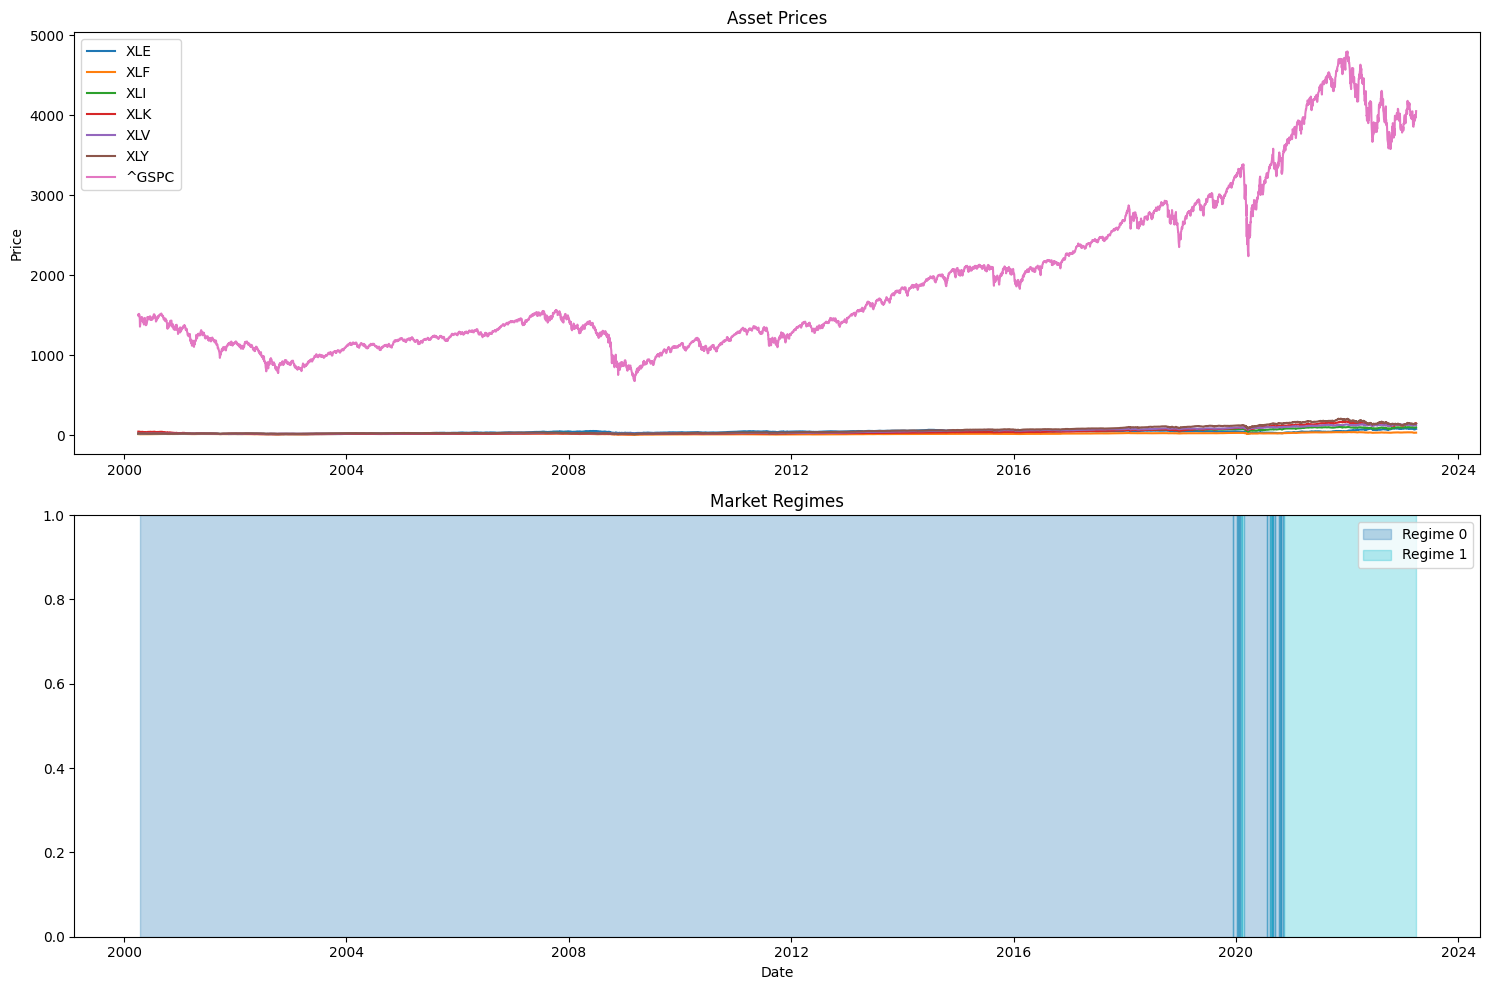


Regime Analysis:

Regime 0 (5137 days):
  XLE: Avg Return: 0.02%, Avg Volatility: 1.49%, Max Return: 16.47%, Min Return: -20.14%
  XLF: Avg Return: 0.03%, Avg Volatility: 1.41%, Max Return: 16.46%, Min Return: -16.67%
  XLI: Avg Return: 0.03%, Avg Volatility: 1.13%, Max Return: 12.65%, Min Return: -11.34%
  XLK: Avg Return: 0.03%, Avg Volatility: 1.30%, Max Return: 16.10%, Min Return: -13.81%
  XLV: Avg Return: 0.04%, Avg Volatility: 0.95%, Max Return: 12.05%, Min Return: -9.86%
  XLY: Avg Return: 0.04%, Avg Volatility: 1.15%, Max Return: 9.78%, Min Return: -12.67%
  ^GSPC: Avg Return: 0.02%, Avg Volatility: 0.99%, Max Return: 11.58%, Min Return: -11.98%
  Characteristic: Mixed/Transition Regime

Regime 1 (639 days):
  XLE: Avg Return: 0.24%, Avg Volatility: 1.96%, Max Return: 14.28%, Min Return: -8.27%
  XLF: Avg Return: 0.09%, Avg Volatility: 1.26%, Max Return: 8.21%, Min Return: -4.06%
  XLI: Avg Return: 0.08%, Avg Volatility: 1.08%, Max Return: 4.20%, Min Return: -3.77%
  XLK: Avg

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import warnings
import time
from datetime import timedelta
warnings.filterwarnings('ignore')

#TNC model
class TNCNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32]):
        super(TNCNet, self).__init__()

        layers = []
        prev_dim = input_dim

        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            prev_dim = dim

        self.encoder = nn.Sequential(*layers)
        self.representation_dim = hidden_dims[-1]

    def forward(self, x):
        return self.encoder(x)

class TemporalNeighborhoodCoding:
    def __init__(self, input_dim, hidden_dims=[64, 32], learning_rate=0.001, batch_size=32, w_size=10, weight_decay=0.0):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.model = TNCNet(input_dim, hidden_dims).to(self.device)

        #weight decay to optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        #learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )

        self.batch_size = batch_size
        self.w_size = w_size
        self.early_stopping_patience = 10
        self.best_loss = float('inf')
        self.patience_counter = 0

    def fit(self, data, epochs=50, validation_split=0.2, verbose=True):
        self.data = data
        X_tensor = torch.FloatTensor(data.values).to(self.device)

        dataset_size = len(X_tensor)
        val_size = int(validation_split * dataset_size)
        train_size = dataset_size - val_size

        train_tensor = X_tensor[:train_size]
        val_tensor = X_tensor[train_size:]

        train_dataset = TNCDataset(train_tensor, self.w_size)
        val_dataset = TNCDataset(val_tensor, self.w_size)

        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        self.model.train()
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            self.model.train()
            epoch_loss = 0
            for batch in train_dataloader:
                anchor, pos, neg = batch
                anchor, pos, neg = anchor.to(self.device), pos.to(self.device), neg.to(self.device)
                anchor_rep = self.model(anchor)
                pos_rep = self.model(pos)
                neg_rep = self.model(neg)
                pos_sim = F.cosine_similarity(anchor_rep, pos_rep)
                neg_sim = F.cosine_similarity(anchor_rep, neg_rep)
                loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim))).mean()

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

            avg_train_loss = epoch_loss / len(train_dataloader)
            train_losses.append(avg_train_loss)
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    anchor, pos, neg = batch
                    anchor, pos, neg = anchor.to(self.device), pos.to(self.device), neg.to(self.device)
                    anchor_rep = self.model(anchor)
                    pos_rep = self.model(pos)
                    neg_rep = self.model(neg)
                    pos_sim = F.cosine_similarity(anchor_rep, pos_rep)
                    neg_sim = F.cosine_similarity(anchor_rep, neg_rep)
                    batch_loss = -torch.log(torch.exp(pos_sim) / (torch.exp(pos_sim) + torch.exp(neg_sim))).mean()
                    val_loss += batch_loss.item()

            avg_val_loss = val_loss / len(val_dataloader)
            val_losses.append(avg_val_loss)
            self.scheduler.step(avg_val_loss)
            if avg_val_loss < self.best_loss:
                self.best_loss = avg_val_loss
                self.patience_counter = 0
                torch.save(self.model.state_dict(), 'best_tnc_model.pt')
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.early_stopping_patience:
                if verbose:
                    print(f'Early stopping at epoch {epoch+1}')

                self.model.load_state_dict(torch.load('best_tnc_model.pt'))
                break

            if verbose and (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        return self.best_loss

    def get_representations(self, data=None):
        if data is None:
            data = self.data

        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(data.values).to(self.device)
            representations = self.model(X_tensor).cpu().numpy()

        return representations


class TNCDataset(Dataset):
    def __init__(self, data, w_size=10):
        self.data = data
        self.w_size = w_size
        self.T = len(data)

    def __len__(self):
        return self.T

    def __getitem__(self, idx):
        anchor = self.data[idx]
        pos_idx = np.random.randint(max(0, idx-self.w_size), min(self.T, idx+self.w_size+1))
        while pos_idx == idx:
            pos_idx = np.random.randint(max(0, idx-self.w_size), min(self.T, idx+self.w_size+1))
        positive = self.data[pos_idx]
        if idx - self.w_size <= 0:
            neg_idx = np.random.randint(min(idx + self.w_size + 1, self.T-1), self.T)
        elif idx + self.w_size >= self.T - 1:
            neg_idx = np.random.randint(0, max(0, idx - self.w_size))
        else:
            if np.random.random() < 0.5:
                neg_idx = np.random.randint(0, max(0, idx - self.w_size))
            else:
                neg_idx = np.random.randint(min(idx + self.w_size + 1, self.T-1), self.T)
        if neg_idx >= self.T:
            neg_idx = 0

        negative = self.data[neg_idx]

        return anchor, positive, negative
#using grid search for hyper parameter tuning
def grid_search_hyperparameters(features_df, n_clusters_range=range(2, 6)):
    print("Starting hyperparameter grid search...")
    start_time = time.time()
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)
    scaled_df = pd.DataFrame(scaled_features)
    param_grid = {
        'hidden_dims': [
            [64, 32],
            [128, 64],
            [128, 64, 32],
            [256, 128, 64]
        ],
        'learning_rate': [0.0001, 0.001, 0.01],
        'batch_size': [32, 64, 128],
        'w_size': [5, 10, 15, 20],
        'weight_decay': [0.0, 0.0001, 0.001]
    }

    parameter_combinations = list(ParameterGrid(param_grid))
    print(f"Total parameter combinations to evaluate: {len(parameter_combinations)}")
    results = []
    best_score = -float('inf')
    best_params = None
    best_model = None

    for i, params in enumerate(parameter_combinations):
        print(f"\nEvaluating combination {i+1}/{len(parameter_combinations)}")
        print(params)
        input_dim = scaled_features.shape[1]
        tnc = TemporalNeighborhoodCoding(
            input_dim=input_dim,
            hidden_dims=params['hidden_dims'],
            learning_rate=params['learning_rate'],
            batch_size=params['batch_size'],
            w_size=params['w_size'],
            weight_decay=params['weight_decay']
        )

        try:
            loss = tnc.fit(scaled_df, epochs=50, verbose=False)

            #Get representations
            representations = tnc.get_representations()

            best_silhouette = -1
            best_clusters = 0

            for n_clusters in n_clusters_range:
                kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                labels = kmeans.fit_predict(representations)


                if len(np.unique(labels)) <= 1:
                    continue

                score = silhouette_score(representations, labels)

                if score > best_silhouette:
                    best_silhouette = score
                    best_clusters = n_clusters
            result = {
                'params': params,
                'loss': loss,
                'silhouette_score': best_silhouette,
                'clusters': best_clusters
            }
            results.append(result)

            print(f"Loss: {loss:.4f}, Best Silhouette Score: {best_silhouette:.4f}, Best Clusters: {best_clusters}")

            if best_silhouette > best_score:
                best_score = best_silhouette
                best_params = params.copy()
                best_model = tnc

                torch.save(tnc.model.state_dict(), 'best_grid_search_model.pt')

        except Exception as e:
            print(f"Error with parameters {params}: {str(e)}")
    elapsed_time = time.time() - start_time
    print(f"\nGrid search completed in {timedelta(seconds=elapsed_time)}")
    print(f"Best silhouette score: {best_score:.4f}")
    print("Best parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    results_df = pd.DataFrame(results)
    results_df.to_csv('hyperparameter_search_results.csv', index=False)
    print("Results saved to 'hyperparameter_search_results.csv'")


    plot_hyperparameter_results(results)

    return best_params, best_score, best_model
def plot_hyperparameter_results(results):
    results_df = pd.DataFrame([
        {
            'loss': r['loss'],
            'silhouette_score': r['silhouette_score'],
            'clusters': r['clusters'],
            'hidden_dims': str(r['params']['hidden_dims']),
            'learning_rate': r['params']['learning_rate'],
            'batch_size': r['params']['batch_size'],
            'w_size': r['params']['w_size'],
            'weight_decay': r['params']['weight_decay']
        }
        for r in results
    ])

    plt.figure(figsize=(10, 6))
    plt.scatter(results_df['loss'], results_df['silhouette_score'], alpha=0.7)
    plt.xlabel('Training Loss')
    plt.ylabel('Silhouette Score')
    plt.title('Relationship between Loss and Clustering Quality')
    plt.grid(True)
    plt.savefig('loss_vs_silhouette.png')
    plt.close()

    #Plot key parameters vs silhouette score
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    #Learning rate
    axes[0, 0].scatter(results_df['learning_rate'], results_df['silhouette_score'], alpha=0.7)
    axes[0, 0].set_xlabel('Learning Rate')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].set_title('Learning Rate vs Silhouette Score')
    axes[0, 0].grid(True)

    #Batch size
    axes[0, 1].scatter(results_df['batch_size'], results_df['silhouette_score'], alpha=0.7)
    axes[0, 1].set_xlabel('Batch Size')
    axes[0, 1].set_ylabel('Silhouette Score')
    axes[0, 1].set_title('Batch Size vs Silhouette Score')
    axes[0, 1].grid(True)

    #Window size
    axes[1, 0].scatter(results_df['w_size'], results_df['silhouette_score'], alpha=0.7)
    axes[1, 0].set_xlabel('Window Size')
    axes[1, 0].set_ylabel('Silhouette Score')
    axes[1, 0].set_title('Window Size vs Silhouette Score')
    axes[1, 0].grid(True)

    #Weight decay
    axes[1, 1].scatter(results_df['weight_decay'], results_df['silhouette_score'], alpha=0.7)
    axes[1, 1].set_xlabel('Weight Decay')
    axes[1, 1].set_ylabel('Silhouette Score')
    axes[1, 1].set_title('Weight Decay vs Silhouette Score')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig('parameter_analysis.png')
    plt.close()

    #Plot network architecture comparison
    plt.figure(figsize=(12, 6))
    architecture_groups = results_df.groupby('hidden_dims')['silhouette_score'].mean().sort_values(ascending=False)
    architecture_groups.plot(kind='bar')
    plt.xlabel('Network Architecture')
    plt.ylabel('Average Silhouette Score')
    plt.title('Network Architecture Performance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('architecture_comparison.png')
    plt.close()

#Optimized TNC model using the best parameters
def create_optimized_tnc(features_df, best_params):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_df)

    #TNC with best parameters
    input_dim = scaled_features.shape[1]
    tnc = TemporalNeighborhoodCoding(
        input_dim=input_dim,
        hidden_dims=best_params['hidden_dims'],
        learning_rate=best_params['learning_rate'],
        batch_size=best_params['batch_size'],
        w_size=best_params['w_size'],
        weight_decay=best_params['weight_decay']
    )


    loss = tnc.fit(pd.DataFrame(scaled_features), epochs=100)
    representations = tnc.get_representations()

    return tnc, representations
def main(data_path='/content/melted_data.csv', do_hyperparameter_search=True, max_combinations=10):
    df = pd.read_csv(data_path)
    features_df, raw_df = prepare_data(df)

    if do_hyperparameter_search:
        best_params, best_score, best_model = grid_search_hyperparameters(features_df)
        representations = best_model.get_representations()
    else:
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features_df)
        print("\nTraining TNC model with default parameters...")
        input_dim = scaled_features.shape[1]
        tnc = TemporalNeighborhoodCoding(
            input_dim=input_dim,
            hidden_dims=[128, 64, 32],
            w_size=15,
            batch_size=64,
            learning_rate=0.001
        )

        tnc.fit(pd.DataFrame(scaled_features), epochs=100)

        print("\nExtracting learned representations...")
        representations = tnc.get_representations()
        best_model = tnc
    print("\nClustering and evaluating with silhouette score...")
    best_clustering_model, best_n_clusters, best_silhouette = cluster_and_evaluate(representations)

    if best_silhouette < 0:
        print("\nWarning: Best silhouette score is negative. Trying different approaches...")
        labels, best_n_clusters, best_silhouette = improve_silhouette_score(representations)
    else:
        labels = best_clustering_model.labels_

    print("\nVisualizing market regimes...")
    regime_dates = visualize_regimes(raw_df, features_df, labels, best_n_clusters)
    regime_df = analyze_regimes(raw_df, features_df, labels, best_n_clusters)

    print(f"\nFinal Silhouette Score: {best_silhouette:.4f}")
    regime_output = pd.DataFrame({
        'Date': regime_dates.index,
        'Regime': regime_dates['Regime']
    })
    regime_output.to_csv('market_regimes.csv', index=False)
    print("\nRegime assignments saved to 'market_regimes.csv'")
    torch.save(best_model.model.state_dict(), 'final_tnc_model.pt')
    print("Model saved to 'final_tnc_model.pt'")
    if do_hyperparameter_search:
        with open('best_hyperparameters.txt', 'w') as f:
            f.write("Best hyperparameters:\n")
            for param, value in best_params.items():
                f.write(f"{param}: {value}\n")
        print("Best hyperparameters saved to 'best_hyperparameters.txt'")

    return regime_df, best_silhouette, representations, best_model

if __name__ == "__main__":
    regime_df, silhouette_score, representations, tnc_model = main(
        '/content/melted_data.csv',
        do_hyperparameter_search=True
    )